In [2]:
from src.functions import *

In [3]:
T = 0.1
n = 4
scope = 'custom'

In [4]:
# NOTE: We evaluate the algorithm on the SAME 10 random instances for each grid point

# Grid search

In [5]:
if scope == 'zoomed':
    # Zoomed in search
    gamma_lims = (0,1) # Range of gamma values
    gamma_steps = 50
    time_lims = (0,20) # Range of time values
    time_steps = 50
elif scope == 'broad':
    # Broad search
    gamma_lims = (0.2,3) # Range of gamma values
    gamma_steps = 50
    time_lims = (0,100) # Range of time values
    time_steps = 50
elif scope == 'custom':
    gamma_lims = (0,1) 
    gamma_steps = 50
    time_lims = (0,30) 
    time_steps = 50

gamma_range = np.linspace(gamma_lims[0], gamma_lims[1], gamma_steps)
time_range = np.linspace(time_lims[0], time_lims[1], time_steps)

num_random_models = 100

def f_1(t):
    '''
    Calculate spectral gaps for quantum proposal.
    f_1(t) is defined to parallelize the time-loop.
    '''    
    delta_quantum_arr = np.zeros((gamma_steps, num_random_models))
    
    for gamma_id, gamma in enumerate(gamma_range):
        for i in range(num_random_models):
            m = RandomIsingModel(n, seed=i)
            # Calculate delta for quantum proposal
            proposal_mat_quantum = get_proposal_mat_quantum(m, gamma, t)
            P_quantum = get_transition_matrix(m, T, proposal_mat_quantum)
            delta_quantum = get_delta(P_quantum)
            delta_quantum_arr[gamma_id, i] = delta_quantum

    return delta_quantum_arr

def f_2(t):
    '''
    Calculate spectral gaps for quantum and mismatched proposals.
    f_2(t) is defined to parallelize the time-loop.
    '''    
    delta_quantum_arr = np.zeros((gamma_steps, num_random_models))
    delta_mismatched_quantum_arr = np.zeros((gamma_steps, num_random_models))
    for gamma_id, gamma in enumerate(gamma_range):
        for i in range(num_random_models):
            m = RandomIsingModel(n, seed=i)
            # Calculate delta for quantum proposal
            proposal_mat_quantum = get_proposal_mat_quantum(m, gamma, t)
            P_quantum = get_transition_matrix(m, T, proposal_mat_quantum)
            delta_quantum = get_delta(P_quantum)
            delta_quantum_arr[gamma_id, i] = delta_quantum

            # Calculate delta for mismatched quantum proposal
            m_mismatched = RandomIsingModel(n)
            proposal_mat_mismatched_quantum = get_proposal_mat_quantum(m_mismatched, gamma, t)
            P_mismatched_quantum = get_transition_matrix(m, T, proposal_mat_mismatched_quantum)
            delta_mismatched_quantum = get_delta(P_mismatched_quantum)
            delta_mismatched_quantum_arr[gamma_id, i] = delta_mismatched_quantum

    return delta_quantum_arr, delta_mismatched_quantum_arr

In [6]:
sweep_data = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(f_1)(t) for t in tqdm(time_range)))
sweep_data = sweep_data.swapaxes(0,1)

100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


In [7]:
delta_quantum_arr = sweep_data
# delta_mismatched_quantum_arr = sweep_data[1]

# Save the data

In [8]:
grid_search = {'delta': delta_quantum_arr.tolist(),
               'num_random_models': num_random_models,
               'gamma_range': gamma_range.tolist(),
               'time_range': time_range.tolist(),
               'T': T,
               'n': n}

save_in_json(grid_search, f'data/grid_search_n{n}.json')

# Average and plot the results

In [9]:
delta_quantum_arr_avg = np.mean(delta_quantum_arr, axis=2)
delta_quantum_arr_std = np.std(delta_quantum_arr, axis=2)

# delta_mismatched_quantum_arr_avg = np.mean(delta_mismatched_quantum_arr, axis=2)
# delta_mismatched_quantum_arr_std = np.std(delta_mismatched_quantum_arr, axis=2)

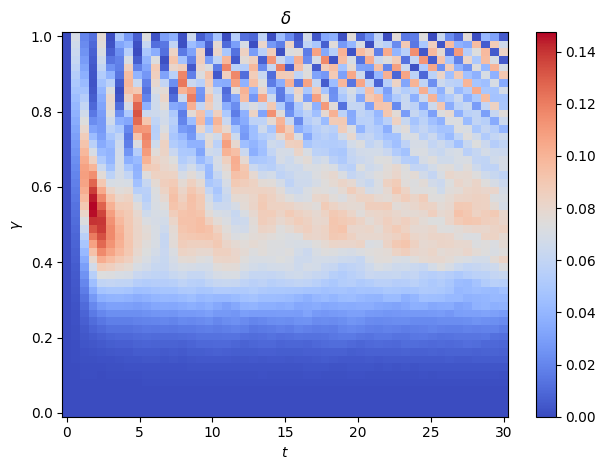

In [10]:
fig = plt.figure()

pc0 = plt.pcolor(time_range, 
                gamma_range,
                delta_quantum_arr_avg, 
                cmap='coolwarm',
                vmin=0,
                vmax=np.max(delta_quantum_arr_avg)
                )
fig.colorbar(pc0)

plt.xlabel('$t$')
plt.ylabel('$\gamma$')
plt.title('$\delta$')

fig.tight_layout()

# fig.savefig(local_path+f'figures/grid_search_n{n}')

In [11]:
# fig, axs = plt.subplot_mosaic([['left', 'upper right'],
#                                ['left', 'lower right']],
#                               figsize=(8, 4),
#                               width_ratios=[2,2])
# fig.suptitle(f'Full grid search | n = {n} | T = {T}')

# pc0 = axs['left'].pcolor(gamma_range,
#                          time_range, 
#                          delta_quantum_arr_avg, 
#                          cmap='coolwarm',
#                          vmin=0,
#                          vmax=np.max(delta_quantum_arr_avg)
#                          )
# fig.colorbar(pc0, ax=axs['left'])

# axs['left'].set_xlabel('$\gamma$')
# axs['left'].set_ylabel('$t$')
# axs['left'].set_title('Quantum')

# axs['upper right'].plot(time_range, np.mean(delta_quantum_arr_avg, axis=1))
# axs['upper right'].set_xlabel('$t$')
# axs['upper right'].set_ylabel('$\delta$')
# axs['upper right'].set_yticks([])
# axs['upper right'].set_title('Average over $\gamma$')

# axs['lower right'].plot(gamma_range, np.mean(delta_quantum_arr_avg, axis=0))
# axs['lower right'].set_xlabel('$\gamma$')
# axs['lower right'].set_ylabel('$\delta$')
# axs['lower right'].set_yticks([])
# axs['lower right'].set_title('Average over $t$')

# fig.tight_layout()

# fig.savefig(f'figures/grid_search_n{n}')

In [12]:
# fig, axs = plt.subplots(1,2, figsize=(10, 4))
# fig.suptitle(f'Full grid search | n = {n} | T = {T}')

# pc0 = axs[0].pcolor(gamma_range, 
#                     time_range, 
#                     delta_mismatched_quantum_arr_avg, 
#                     cmap='coolwarm',
#                     vmin=0,
#                     vmax=np.max(delta_quantum_arr_avg)
#                     )
# fig.colorbar(pc0, ax=axs[0])

# pc1 = axs[1].pcolor(gamma_range, 
#                     time_range, 
#                     delta_quantum_arr_avg - delta_mismatched_quantum_arr_avg, 
#                     cmap='coolwarm',
#                     vmin=-0.1,
#                     vmax=0.1
#                     )
# fig.colorbar(pc1, ax=axs[1])

# axs[0].set_ylabel('$t$')
# axs[0].set_xlabel('$\gamma$')
# axs[0].set_title('Mismatched quantum')

# axs[1].set_ylabel('$t$')
# axs[1].set_xlabel('$\gamma$')
# axs[1].set_title('$\Delta$(Quantum, Mismatched)')

# fig.tight_layout()